In [1]:
%reload_kedro

2023-05-04 14:23:44,332 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-04 14:23:44,849 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-05-04 14:23:44,982 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-05-04 14:23:44,983 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from crypto_thesis.data_domains.spine import spine_build_target_labels

### Label balancing

In [4]:
df_spine_preproc = catalog.load("spine_preprocessing")
df_spine_logret = catalog.load("spine_log_ret")
spine_params = catalog.load("params:spine_labeling")
spine_cls_bds_params = catalog.load("params:spine_class_bounds")

2023-05-04 14:23:46,029 - kedro.io.data_catalog - INFO - Loading data from `spine_preprocessing` (ParquetDataSet)...
2023-05-04 14:23:46,083 - kedro.io.data_catalog - INFO - Loading data from `spine_log_ret` (ParquetDataSet)...
2023-05-04 14:23:46,095 - kedro.io.data_catalog - INFO - Loading data from `params:spine_labeling` (MemoryDataSet)...
2023-05-04 14:23:46,096 - kedro.io.data_catalog - INFO - Loading data from `params:spine_class_bounds` (MemoryDataSet)...


In [5]:
# test a different tau value to evaluate class balancing
spine_params

{'tau': 0.35}

In [6]:
df_spine_lbl = spine_build_target_labels(df=df_spine_preproc, 
                                         df_log_ret=df_spine_logret, 
                                         label_params=spine_params,
                                        class_bounds=spine_cls_bds_params)

2023-05-04 14:23:51,443 - crypto_thesis.data_domains.spine.build_labels - INFO - Checking for class balance


In [7]:
df_spine_lbl.label.value_counts() / df_spine_lbl.shape[0]

bottom    0.5
top       0.5
Name: label, dtype: float64

### Volume bar time interval plots

In [8]:
df_spine = catalog.load("spine_labeled")
df_ftes = catalog.load("fte_binance").dropna()

2023-05-04 14:23:51,458 - kedro.io.data_catalog - INFO - Loading data from `spine_labeled` (ParquetDataSet)...
2023-05-04 14:23:51,465 - kedro.io.data_catalog - INFO - Loading data from `fte_binance` (ParquetDataSet)...


In [9]:
df_spine_aux = df_spine.copy()

df_spine_aux = df_spine_aux.merge(df_ftes[["open_time", "close_time"]], \
                                  on=["open_time", "close_time"] , \
                                 how="inner")

df_spine_aux.loc[:, "open_close_duration_sec"] = (df_spine_aux["close_time"] - df_spine_aux["open_time"]).dt.total_seconds()
df_spine_aux.loc[:, "close_target_duration_sec"] = (df_spine_aux["target_time"] - df_spine_aux["close_time"]).dt.total_seconds()

df_spine_aux.loc[:, "open_close_duration_min"] = df_spine_aux["open_close_duration_sec"] / 60.0
df_spine_aux.loc[:, "close_target_duration_min"] = df_spine_aux["close_target_duration_sec"] / 60.0

In [10]:
df_spine_aux.head()

,open_time,close_time,target_time,logret_cumsum,target_time_close,target_time_log_return,close_time_close,std,close_to_tgt_time_logret,pctchg_cumsum,close_to_tgt_time_pctchg,label,open_close_duration_sec,close_target_duration_sec,open_close_duration_min,close_target_duration_min
0,2022-12-26 22:15:00,2022-12-27 05:30:00,2022-12-27 13:15:00,0.001845,16833.35,0.000296,16875.49,0.001055,-0.002500,0.001846,-0.002497,bottom,26100.0,27900.0,435.0,465.0
1,2021-07-21 16:15:00,2021-07-22 08:15:00,2021-07-23 10:00:00,0.008134,32303.81,-0.000661,32249.23,0.004439,0.001691,0.008167,0.001692,bottom,57600.0,92700.0,960.0,1545.0
2,2022-11-05 13:00:00,2022-11-05 17:30:00,2022-11-06 00:15:00,0.000589,21307.40,-0.000242,21323.15,0.001397,-0.000739,0.000589,-0.000739,bottom,16200.0,24300.0,270.0,405.0
3,2022-11-04 12:30:00,2022-11-04 13:15:00,2022-11-04 14:30:00,0.017108,21231.30,0.004403,20867.61,0.002311,0.017278,0.017255,0.017428,bottom,2700.0,4500.0,45.0,75.0
4,2020-10-29 12:45:00,2020-10-30 02:15:00,2020-10-30 17:15:00,0.034411,13500.64,-0.002458,13545.74,0.003259,-0.003335,0.035010,-0.003329,bottom,48600.0,54000.0,810.0,900.0


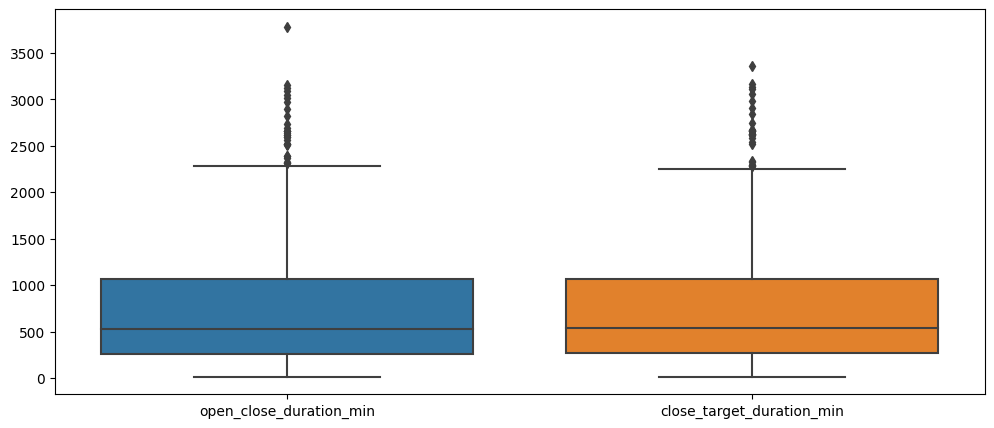

In [11]:
df_plot = df_spine_aux[["close_time", "open_close_duration_min", "close_target_duration_min"]] \
                        .set_index("close_time") \
                        .sort_index()

plt.figure(figsize=(12, 5))

# plot = sns.boxplot(data=df_plot, palette="gray")
plot = sns.boxplot(data=df_plot)

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_boxplot_time_windows.png")

In [12]:
df_plot.describe()

,open_close_duration_min,close_target_duration_min
count,1703.000000,1703.000000
mean,712.204932,724.219025
std,578.553139,575.913830
min,15.000000,15.000000
25%,255.000000,270.000000
50%,525.000000,540.000000
75%,1065.000000,1065.000000
max,3780.000000,3360.000000
